# Setup

In [24]:
# Import libs
import pandas as pd
import json as json
from pandas import json_normalize
import os
pd.set_option('display.max_columns', None)

# Data Exploration
## Exploring in a Single Container

We start by analyzing the first container.

In [2]:
# Read first container data
srcDir = '../data/raw/'
string = open(srcDir+'70b3d500700016dA.txt','r').read()
jsonData = json.loads(string)
df = pd.DataFrame(jsonData[1])

We print out the data frame info. The sample container has 6 fields and 7306 rows.

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7306 entries, 0 to 7305
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7306 non-null   object
 1   deveui        7306 non-null   object
 2   unix_time     7306 non-null   object
 3   client_id     7306 non-null   object
 4   created_at    7306 non-null   object
 5   decoded_data  7306 non-null   object
dtypes: object(6)
memory usage: 342.6+ KB
None


When we look at the first few rows, we can see that decoded_data is a nested list.

In [4]:
print(df.head())

        id            deveui      unix_time     client_id  \
0  4110576  70B3D500700016DA  1620498360377  FES Receiver   
1  4110093  70B3D500700016DA  1620494765501  FES Receiver   
2  4109607  70B3D500700016DA  1620491158880  FES Receiver   
3  4109118  70B3D500700016DA  1620487559091  FES Receiver   
4  4108627  70B3D500700016DA  1620483959154  FES Receiver   

                   created_at  \
0  2021-05-08 20:26:00.596017   
1  2021-05-08 19:26:05.713448   
2  2021-05-08 18:25:59.323267   
3  2021-05-08 17:25:59.523137   
4  2021-05-08 16:25:59.577446   

                                        decoded_data  
0  {'sensor_data': {'Status': ['SS', 'Standalone'...  
1  {'sensor_data': {'Status': ['SS', 'Standalone'...  
2  {'sensor_data': {'Status': ['SS', 'Standalone'...  
3  {'sensor_data': {'Status': ['SS', 'Standalone'...  
4  {'sensor_data': {'Status': ['SS', 'Standalone'...  


We normalize the JSON data to flatten the data frame. 

In [5]:
normalized_df = json_normalize(jsonData[1])
print(normalized_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7306 entries, 0 to 7305
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   id                                    7306 non-null   object
 1   deveui                                7306 non-null   object
 2   unix_time                             7306 non-null   object
 3   client_id                             7306 non-null   object
 4   created_at                            7306 non-null   object
 5   decoded_data.sensor_data.Status       7306 non-null   object
 6   decoded_data.sensor_data.Sensor ID    7306 non-null   object
 7   decoded_data.sensor_data.Events       7306 non-null   object
 8   decoded_data.sensor_data.Height 1     7306 non-null   object
 9   decoded_data.sensor_data.Height 2     7306 non-null   object
 10  decoded_data.sensor_data.Height 3     7306 non-null   object
 11  decoded_data.sensor_data.Heigh

## Combining the Containers
In the next step, we combine all 77 available container data sets into one dataframe.

In [6]:
data = []
df_all = pd.DataFrame(columns=normalized_df.columns)

for filename in os.listdir(srcDir):
    if filename.endswith(".txt"): 
        print(os.path.join(srcDir, filename))
        string = open(srcDir+filename,'r').read()
        jsonData = json.loads(string)
        df_all = df_all.append(json_normalize(jsonData[1]))   
        
df_all = df_all.reset_index(drop=True)

../data/raw/70b3d500700016dA.txt
../data/raw/70b3d500700016dE.txt
../data/raw/70b3d500700016dF.txt
../data/raw/70b3d500700016E0.txt
../data/raw/70b3d500700016E5.txt
../data/raw/70b3d500700016E6.txt
../data/raw/70b3d500700016E7.txt
../data/raw/70b3d500700016EB.txt
../data/raw/70b3d500700016EE.txt
../data/raw/70b3d500700016F1.txt
../data/raw/70b3d500700016F2.txt
../data/raw/70b3d500700016F4.txt
../data/raw/70b3d500700016F6.txt
../data/raw/70b3d500700016F7.txt
../data/raw/70b3d500700016FA.txt
../data/raw/70b3d500700016FC.txt
../data/raw/70b3d50070001700.txt
../data/raw/70b3d50070001701.txt
../data/raw/70b3d50070001704.txt
../data/raw/70b3d50070001706.txt
../data/raw/70b3d50070001708.txt
../data/raw/70b3d50070001709.txt
../data/raw/70b3d5007000170F.txt
../data/raw/70b3d50070001710.txt
../data/raw/70b3d50070001712.txt
../data/raw/70b3d50070001713.txt
../data/raw/70b3d50070001714.txt
../data/raw/70b3d50070001715.txt
../data/raw/70b3d50070001716.txt
../data/raw/70b3d5007000171A.txt
../data/ra

Now we can explore the whole dataset in a flattened structure. 

*decoded_data.gws_data.gws ist still a nested json object!*

In [7]:
def flatten_nested_json_df(df):

    df = df.reset_index()

    print(f"original shape: {df.shape}")
    print(f"original columns: {df.columns}")


    # search for columns to explode/flatten
    s = (df.applymap(type) == list).all()
    list_columns = s[s].index.tolist()

    s = (df.applymap(type) == dict).all()
    dict_columns = s[s].index.tolist()

    print(f"lists: {list_columns}, dicts: {dict_columns}")
    while len(list_columns) > 0 or len(dict_columns) > 0:
        new_columns = []

        for col in dict_columns:
            print(f"flattening: {col}")
            # explode dictionaries horizontally, adding new columns
            horiz_exploded = pd.json_normalize(df[col]).add_prefix(f'{col}.')
            horiz_exploded.index = df.index
            df = pd.concat([df, horiz_exploded], axis=1).drop(columns=[col])
            new_columns.extend(horiz_exploded.columns) # inplace

        for col in list_columns:
            print(f"exploding: {col}")
            # explode lists vertically, adding new columns
            df = df.drop(columns=[col]).join(df[col].explode().to_frame())
            new_columns.append(col)

        # check if there are still dict o list fields to flatten
        s = (df[new_columns].applymap(type) == list).all()
        list_columns = s[s].index.tolist()

        s = (df[new_columns].applymap(type) == dict).all()
        dict_columns = s[s].index.tolist()

        print(f"lists: {list_columns}, dicts: {dict_columns}")

    print(f"final shape: {df.shape}")
    print(f"final columns: {df.columns}")
    return df

df_all = flatten_nested_json_df(df_all)

original shape: (515037, 31)
original columns: Index(['index', 'id', 'deveui', 'unix_time', 'client_id', 'created_at',
       'decoded_data.sensor_data.Status', 'decoded_data.sensor_data.Sensor ID',
       'decoded_data.sensor_data.Events', 'decoded_data.sensor_data.Height 1',
       'decoded_data.sensor_data.Height 2',
       'decoded_data.sensor_data.Height 3',
       'decoded_data.sensor_data.Height 4', 'decoded_data.sensor_data.Voltage',
       'decoded_data.sensor_data.Temperature', 'decoded_data.sensor_data.Tilt',
       'decoded_data.sensor_data.Tx Event',
       'decoded_data.sensor_data.Messagetype', 'decoded_data.gws_data.cmd',
       'decoded_data.gws_data.seqno', 'decoded_data.gws_data.EUI',
       'decoded_data.gws_data.ts', 'decoded_data.gws_data.fcnt',
       'decoded_data.gws_data.port', 'decoded_data.gws_data.freq',
       'decoded_data.gws_data.toa', 'decoded_data.gws_data.dr',
       'decoded_data.gws_data.ack', 'decoded_data.gws_data.gws',
       'decoded_data.gws_d

In [8]:
print(df_all.info())
print(df_all.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7878096 entries, 0 to 515036
Data columns (total 39 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   index                                 int64  
 1   id                                    object 
 2   deveui                                object 
 3   unix_time                             object 
 4   client_id                             object 
 5   created_at                            object 
 6   decoded_data.sensor_data.Sensor ID    object 
 7   decoded_data.sensor_data.Events       object 
 8   decoded_data.sensor_data.Height 1     object 
 9   decoded_data.sensor_data.Height 2     object 
 10  decoded_data.sensor_data.Height 3     object 
 11  decoded_data.sensor_data.Height 4     object 
 12  decoded_data.sensor_data.Voltage      object 
 13  decoded_data.sensor_data.Temperature  object 
 14  decoded_data.sensor_data.Tilt         object 
 15  decoded_data.sen

Output distinct Sensor IDs. We can use it to identify the different containers.

In [9]:
print("The dataset has", len(df_all['decoded_data.sensor_data.Sensor ID'].unique()), "distinct Sensor ID's.")

The dataset has 77 distinct Sensor ID's.


Aggregate data count for each container and plot it in a bar chart. Here we can see that 3 containers have a much lower data coverage (~2000) than the rest of them.

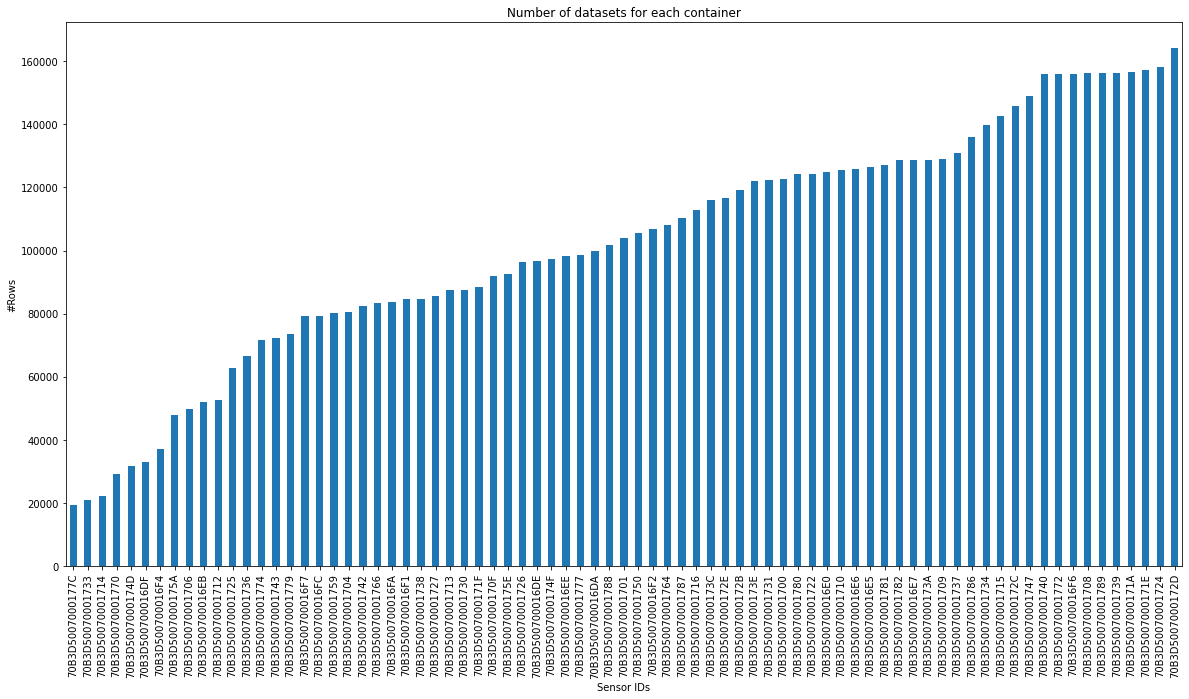

In [10]:
# Sensor ID and deveui and decoded_data.gws_data.EUI can all be used
#df_count = df_all.groupby(['decoded_data.sensor_data.Sensor ID']).size()
df_count = df_all.groupby(['deveui']).size()
df_count = df_count.sort_values(ascending=True)
ax = df_count.plot.bar(xlabel='Sensor IDs', ylabel='#Rows', figsize=(20,10), title='Number of datasets for each container')

This plot can be constructed using either "DEVEUI" or "decoded_data.sensor_data.Sensor ID" or "decoded_data.gws_data.EUI". "DEVEUI" seems to be the ID of a container, while  "decoded_data.sensor_data.Sensor ID" is the ID of a single sensor. We check if they have a 1-1 relation.

In [11]:
print("Es gibt", df_all["deveui"].unique().size, "DEVEUI's und", df_all["decoded_data.sensor_data.Sensor ID"].unique().size, "Sensor ID's")

df_all.groupby(["deveui", "decoded_data.sensor_data.Sensor ID"]).size().reset_index()

Es gibt 77 DEVEUI's und 77 Sensor ID's


,deveui,decoded_data.sensor_data.Sensor ID,0
0,70B3D500700016DA,700016da,99873
1,70B3D500700016DE,700016de,96804
2,70B3D500700016DF,700016df,32913
3,70B3D500700016E0,700016e0,124875
4,70B3D500700016E5,700016e5,126414
...,...,...,...
72,70B3D50070001782,70001782,128619
73,70B3D50070001786,70001786,135918
74,70B3D50070001787,70001787,110295
75,70B3D50070001788,70001788,101718


We see, that both fields "DEVEUI", and "...SENSOR ID" have 77 Values. The have a 1-1 relation, because when we group them, we get 77 distinct values.

## Time Dimension Graphs

We start off by parsing the unix time to a datetime64 format. !!!ACHTUNG!!! UNIX TIME != CREATED TIME --> LocalTime vor dem Parsen einstellen?

In [12]:
from datetime import datetime
df_all["parsed_time"] = pd.to_datetime(df_all['unix_time'],unit='ms')

df_all['parsed_time_week'] = df_all['parsed_time'].dt.isocalendar().week
df_all['parsed_time_month'] = pd.DatetimeIndex(df_all['parsed_time']).month
df_all['parsed_time_year'] = pd.DatetimeIndex(df_all['parsed_time']).year
df_all['parsed_time_monthyear'] = df_all['parsed_time_year'].astype(str) + "/" + df_all['parsed_time_month'].astype(str)
df_all['parsed_time_weekyear'] = df_all['parsed_time_year'].astype(str) + "/" + df_all['parsed_time_week'].astype(str)

Now we can look at observations on a timeline

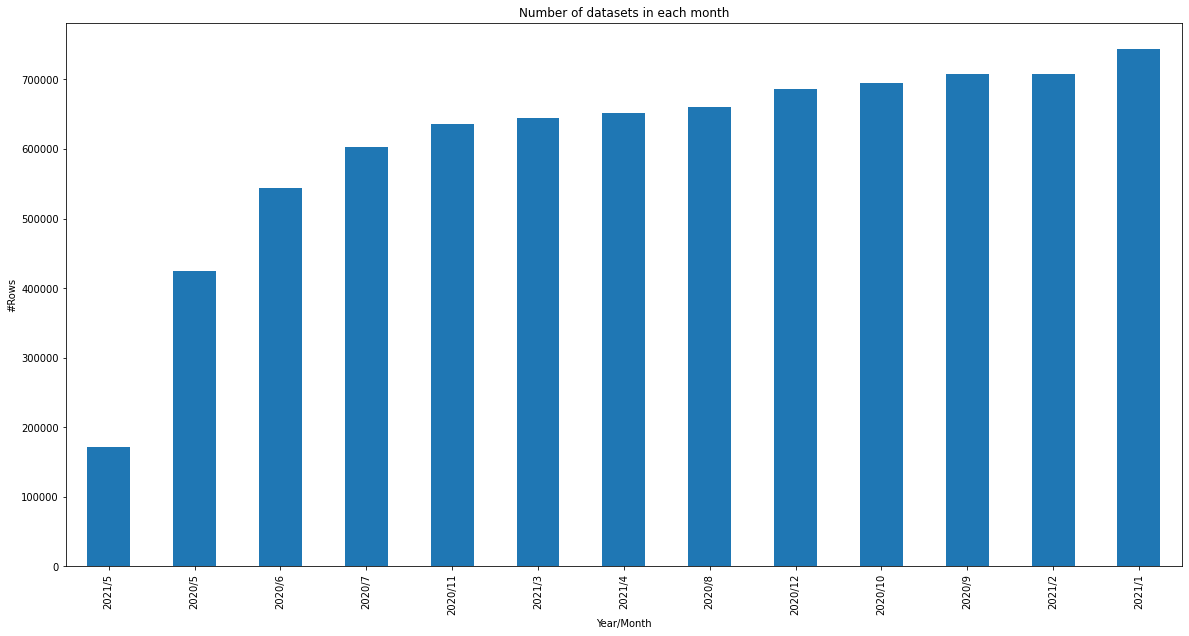

In [13]:
df_years = df_all.groupby(['parsed_time_monthyear']).size()
df_years = df_years.sort_values(ascending=True)
ax = df_years.plot.bar(xlabel='Year/Month', ylabel='#Rows', figsize=(20,10), title='Number of datasets in each month')

Or based on weeks

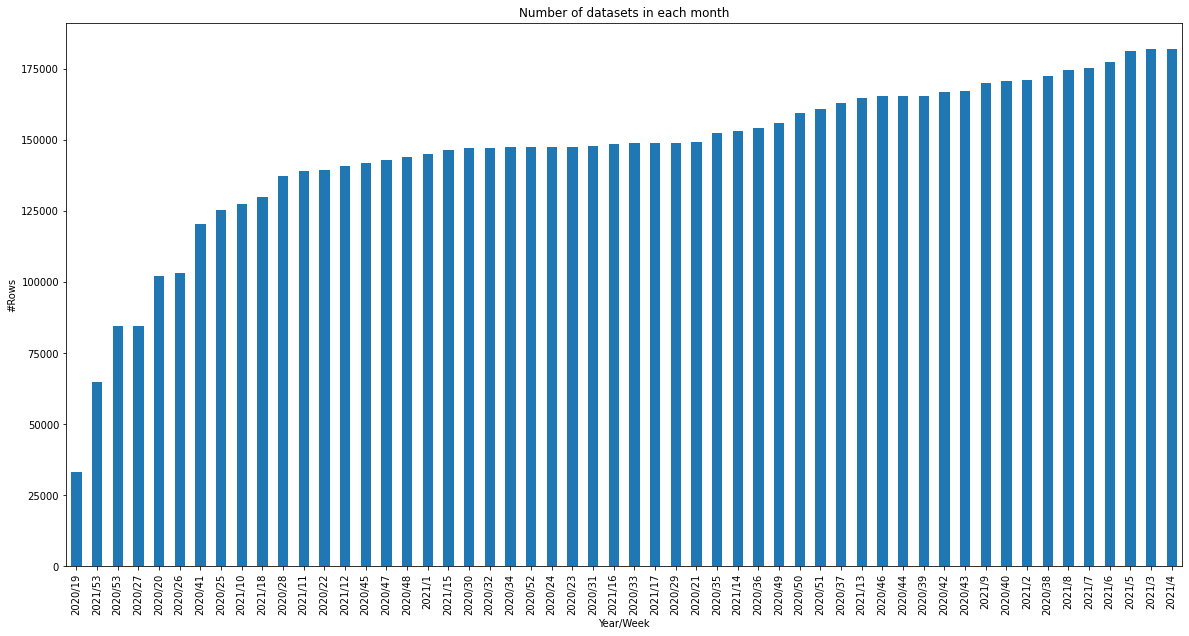

In [14]:
df_years = df_all.groupby(['parsed_time_weekyear']).size()
df_years = df_years.sort_values(ascending=True)
ax = df_years.plot.bar(xlabel='Year/Week', ylabel='#Rows', figsize=(20,10), title='Number of datasets in each month')

## Describing all fields

In [25]:
df_all

,index,id,deveui,unix_time,client_id,created_at,decoded_data.sensor_data.Sensor ID,decoded_data.sensor_data.Events,decoded_data.sensor_data.Height 1,decoded_data.sensor_data.Height 2,decoded_data.sensor_data.Height 3,decoded_data.sensor_data.Height 4,decoded_data.sensor_data.Voltage,decoded_data.sensor_data.Temperature,decoded_data.sensor_data.Tilt,decoded_data.sensor_data.Tx Event,decoded_data.sensor_data.Messagetype,decoded_data.gws_data.cmd,decoded_data.gws_data.seqno,decoded_data.gws_data.EUI,decoded_data.gws_data.ts,decoded_data.gws_data.fcnt,decoded_data.gws_data.port,decoded_data.gws_data.freq,decoded_data.gws_data.toa,decoded_data.gws_data.dr,decoded_data.gws_data.ack,decoded_data.gws_data.bat,decoded_data.gws_data.data,decoded_data.sensor_data.Status,decoded_data.gws_data.gws.rssi,decoded_data.gws_data.gws.snr,decoded_data.gws_data.gws.ts,decoded_data.gws_data.gws.tmms,decoded_data.gws_data.gws.time,decoded_data.gws_data.gws.gweui,decoded_data.gws_data.gws.ant,decoded_data.gws_data.gws.lat,decoded_data.gws_data.gws.lon,parsed_time,parsed_time_week,parsed_time_month,parsed_time_year,parsed_time_monthyear,parsed_time_weekyear
0,0,4110576,70B3D500700016DA,1620498360377,FES Receiver,2021-05-08 20:26:00.596017,700016da,SENS_EVENT_MEASURE,112 cm,112 cm,112 cm,112 cm,3620 mV,14 C,1 Degree,193 Times,1.1.1.1,gw,1949379,70B3D500700016DA,1620498360377,4097,2,867500000,123,SF8 BW125 4/5,False,254,ffff22b8da1600700138383838700e01c1,SS,-105,4.5,1620498360377,2000.0,2021-05-08T18:26:00.879996940Z,647FDAFFFF00849A,0.0,50.132245,8.706452,2021-05-08 18:26:00.377,18,5,2021,2021/5,2021/18
0,0,4110576,70B3D500700016DA,1620498360377,FES Receiver,2021-05-08 20:26:00.596017,700016da,SENS_EVENT_MEASURE,112 cm,112 cm,112 cm,112 cm,3620 mV,14 C,1 Degree,193 Times,1.1.1.1,gw,1949379,70B3D500700016DA,1620498360377,4097,2,867500000,123,SF8 BW125 4/5,False,254,ffff22b8da1600700138383838700e01c1,SS,-105,4.5,1620498360377,2000.0,2021-05-08T18:26:00.879996940Z,647FDAFFFF00849A,0.0,50.132245,8.706452,2021-05-08 18:26:00.377,18,5,2021,2021/5,2021/18
0,0,4110576,70B3D500700016DA,1620498360377,FES Receiver,2021-05-08 20:26:00.596017,700016da,SENS_EVENT_MEASURE,112 cm,112 cm,112 cm,112 cm,3620 mV,14 C,1 Degree,193 Times,1.1.1.1,gw,1949379,70B3D500700016DA,1620498360377,4097,2,867500000,123,SF8 BW125 4/5,False,254,ffff22b8da1600700138383838700e01c1,SS,-105,4.5,1620498360377,2000.0,2021-05-08T18:26:00.879996940Z,647FDAFFFF00849A,0.0,50.132245,8.706452,2021-05-08 18:26:00.377,18,5,2021,2021/5,2021/18
0,0,4110576,70B3D500700016DA,1620498360377,FES Receiver,2021-05-08 20:26:00.596017,700016da,SENS_EVENT_MEASURE,112 cm,112 cm,112 cm,112 cm,3620 mV,14 C,1 Degree,193 Times,1.1.1.1,gw,1949379,70B3D500700016DA,1620498360377,4097,2,867500000,123,SF8 BW125 4/5,False,254,ffff22b8da1600700138383838700e01c1,Standalone,-105,4.5,1620498360377,2000.0,2021-05-08T18:26:00.879996940Z,647FDAFFFF00849A,0.0,50.132245,8.706452,2021-05-08 18:26:00.377,18,5,2021,2021/5,2021/18
0,0,4110576,70B3D500700016DA,1620498360377,FES Receiver,2021-05-08 20:26:00.596017,700016da,SENS_EVENT_MEASURE,112 cm,112 cm,112 cm,112 cm,3620 mV,14 C,1 Degree,193 Times,1.1.1.1,gw,1949379,70B3D500700016DA,1620498360377,4097,2,867500000,123,SF8 BW125 4/5,False,254,ffff22b8da1600700138383838700e01c1,Standalone,-105,4.5,1620498360377,2000.0,2021-05-08T18:26:00.879996940Z,647FDAFFFF00849A,0.0,50.132245,8.706452,2021-05-08 18:26:00.377,18,5,2021,2021/5,2021/18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515036,515036,597775,70B3D50070001789,1588978215547,hi3,2020-05-09 00:50:15.726339,70001789,SENS_EVENT_MEASURE,86 cm,86 cm,86 cm,86 cm,3630 mV,22 C,7 Degree,138 Times,NaN,gw,275784,70B3D50070001789,1588978215547,1924,2,867700000,905,SF11 BW125 4/5,False,254,ffff22b889170070012b2b2b2b7116078a,version_184,-121,-2.2,1588978215575,2000.0,2020-05-08T22:50:16.175273579Z,647FDAFFFF00

In [21]:
df_all["decoded_data.gws_data.gws.snr"].describe()


#'decoded_data.gws_data.gws.snr'    
#'decoded_data.gws_data.gws.ts'
#'decoded_data.gws_data.gws.tmms'
#'decoded_data.gws_data.gws.time'
#'decoded_data.gws_data.gws.gweui'
#'decoded_data.gws_data.gws.ant'
#'decoded_data.gws_data.gws.lat'
#'decoded_data.gws_data.gws.lon'


count    7.878096e+06
mean    -3.056422e+00
std      7.351406e+00
min     -2.180000e+01
25%     -8.200000e+00
50%     -3.800000e+00
75%      2.800000e+00
max      1.580000e+01
Name: decoded_data.gws_data.gws.snr, dtype: float64

Welche sind unklar?
- decoded_data.sensor_data.Events (Es gibt 2 Events SENS_EVENT_MEASURE, SENS_EVENT_TILT)
    - Gibt es vlt. ein automatisches Messevent (Zeitbasiert) und eins, dass über Erschütterung getriggert wird?
- Warum Height 4x gleich enthalten?
- decoded_data.gws_data.seqno --> Was bedeuted die? Autoincrement?
- decoded_data.gws_data.ts --> eindeutiger identifier für eine messung? (514859 / 515037 unique values)
- decoded_data.gws_data.fcnt --> bedeutung?
- decoded_data.gws_data.freq --> 8 unique values,  bedeutung?
- decoded_data.gws_data.toa  --> 13 unique values, bedeutung?
- decoded_data.gws_data.dr --> 6 unique values,  bedeutung?
- decoded_data.gws_data.ack (False oder True)
- decoded_data.gws_data.bat (63 unique values, meistens 254)
- decoded_data.gws_data.gws.rssi --> mean: -1.13, range = -1.33 - -5.5, bedeutung?
- decoded_data.gws_data.gws.snr --> bedeutung?
- decoded_data.gws_data.gws.ts --> bedeutung?
- decoded_data.gws_data.gws.tmms --> bedeutung?
- decoded_data.gws_data.gws.ant --> bedeutung?


TODOS:
- decoded_data.sensor_data.Tx Event --> Sollte man noch refactoren, damit "Times" weg ist
- decoded_data.sensor_data.Tilt --> Abhängigkeit zu sensor_data.Events (SENS_EVENT_TILT)?
- GEO berechnen
    - decoded_data.gws_data.gws.lat
    - decoded_data.gws_data.gws.lon
